# Import

In [3]:
!pip install colour

In [4]:
from google.colab import drive
import scipy.io
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from os.path import dirname, basename, isfile, join
import math
import pandas as pd
from statistics import mode
#import pysal
from scipy.stats.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
import random
import networkx as nx
import pickle
from collections import Counter
from scipy.spatial import Voronoi, voronoi_plot_2d
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
import scipy.ndimage as ndimage
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters

In [0]:
time_frame = 15
n_scramble=1000
cell_line = "b16f10"
treatment = "RPMI-AA+15uM aMSH C' dots"
signal_analyzed = "Sytox"

# Code

In [0]:
class experiment:
    def __init__(self, file, time_frame, cell_line, treatment, signal_analyzed):
      mat=scipy.io.loadmat(file)
      self.file_name = file.replace(".mat", "")
      self.treatment_type=self.file_name[:self.file_name.find("_")]
      self.time_frame = time_frame
      self.cell_line = cell_line
      self.treatment = treatment
      self.death_type = "Apoptosis" if 'TRAIL' in treatment else "Necroptosis" if 'VAD' in treatment else "Feroptosis"
      self.signal_analyzed = signal_analyzed
      self.n_cells = len(mat["Centroids2"])
      self.num_iterations = len(mat["numBlobs"])
      self.locations = mat["Centroids2"]
      self.lisX, self.lisY = [x[0] for x in self.locations], [x[1] for x in self.locations]
      self.die_times=self.extract_die_times(mat["numBlobs"])
  
    def extract_die_times(self, iterations):
      times = []
      for u in range(len(iterations)):
        for x in range(iterations[u][0]):
          times.append(u)
      return times

In [0]:
file = '/content/drive/My Drive/School/Masters/Thesis/data copy/20160909_b16f10_aMSH_xy38.mat'
exp = experiment(file, time_frame, cell_line, treatment, signal_analyzed)

## Statistical Test

The statistical test creates 1000 (changeable in parameters) permutations, each with a scramble of the XY locations of each cell. We then check the average difference in death times between neighbors for each permutation. We assume that if the original experiment is better than 995 experiments then there is a connection between neighbors death times. 

Output: 
* mean - average death times between neighbors in the original experiment
* scramble_mean - average death times between neighbors in the permutations
* score - the statistical score (how many of the permutations were better than the original)
* scramble_95_perc - average death times between neighbors in the best 95th permutation
* scramble_98_perc - average death times between neighbors in the best 98th permutation

In [0]:
def create_scramble(locations, n_scramble=1000):
  scrambles = []
  for i in range(n_scramble):
    temp_copy = locations.copy()
    np.random.shuffle(temp_copy)
    scrambles.append(temp_copy)
  return scrambles

In [0]:
def get_time_from_neighbors(die_times, points):
  vor = Voronoi(points)
  neighbors = vor.ridge_points
  t = []
  for i in range(len(neighbors)):
    t.append(abs(die_times[neighbors[i][0]] - die_times[neighbors[i][1]]))
  return t

def get_neighbors_difference_death_times(die_times, locations, scrambles):
  times = []
  times.append(get_time_from_neighbors(die_times, locations))
  for i in range(n_scramble):
    times.append(get_time_from_neighbors(die_times, scrambles[i]))
  return times


In [0]:
def calc_mean(l):
  return sum(l) / float(len(l))

In [0]:
def statistical_test(n_scramble, time_frame, neighbors_difference_death_times):
  better = 0
  means = []
  real_mean = calc_mean(neighbors_difference_death_times[0])
  mean=real_mean * time_frame
  for i in range(n_scramble):
    temp_mean = calc_mean(neighbors_difference_death_times[i + 1])
    means.append(temp_mean)
    if temp_mean > real_mean:
      better += 1
  means.sort()
  scramble_95_perc = means[int(n_scramble*5 / 100)] * time_frame
  scramble_98_perc = means[int(n_scramble*1 / 100)] * time_frame
  scramble_mean = (sum(means) / len(means)) * time_frame
  score = better / n_scramble
  return {'mean': mean, 'scramble_mean': scramble_mean, 'score': score, 'scramble_95_perc': scramble_95_perc, 'scramble_98_perc': scramble_98_perc}

    

In [0]:
scrambles = create_scramble(exp.locations, n_scramble)
neighbors_difference_death_times = get_neighbors_difference_death_times(exp.die_times, exp.locations, scrambles)
scores = statistical_test(n_scramble, exp.time_frame, neighbors_difference_death_times)

In [0]:
def draw_scramble_histogram(neighbors_difference_death_times, n_cells, n_scramble):
  bins = np.linspace(0, 20, 20)
  histogram_scramble=[]
  for z in range(n_cells):
    histogram_scramble.append(0)
  for z in range(len(neighbors_difference_death_times[0])):
    for i in range(n_scramble):
      j = i + 1
      histogram_scramble[neighbors_difference_death_times[j][z]]+=1
  avg_scramble_time=[]
  for z in range(len(histogram_scramble)):
    histogram_scramble[z] /= n_scramble
    n=round(histogram_scramble[z])
    for i in range(n):
      avg_scramble_time.append(z)
  c1 = Counter(neighbors_difference_death_times[0])
  normed1 = [x / len(neighbors_difference_death_times[0]) for x in c1.values()]
  plt.bar(c1.keys(), normed1, alpha=0.5, label='Origin')
  c2 = Counter(avg_scramble_time)
  normed2 = [x / len(neighbors_difference_death_times[0]) for x in c2.values()]
  plt.bar(c2.keys(), normed2, alpha=0.5, label='Scramble')
  plt.legend(loc='upper right')
  plt.show()
  plt.clf()

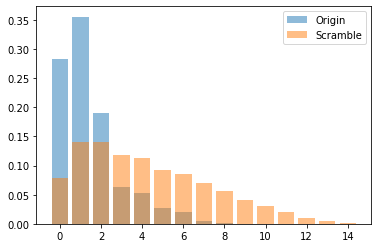

<Figure size 432x288 with 0 Axes>

In [27]:
draw_scramble_histogram(neighbors_difference_death_times, exp.n_cells, n_scramble)

## More Calc

Outputs: 
* distance_from_leader - an array of distances from each cell to the first cell that died.
* neigbors_list - an array, in place i are all the neighbors of i
* neigbors_list2 - an array, in place i are all the neighbors of neighbors of i (second degree neighbors)
* neigbors_list3 - an array, in place i are all the neighbors of neighbors of neighbors of i (third degree neighbors)
* local_leader_flag - an array of the local leader for each cell (local leader is a cell that died before all of its neighbors)
* death_wave_from_local_leader - array that shows the neighbors distance from the closest local leader.

In [0]:
def get_distance_time_from_leader(n_cells, die_times, locations):
  difference_from_leader = []
  for i in range(n_cells):
    time=die_times[i] - die_times[0]
    distance=math.sqrt( ((locations[i][0]-locations[0][0])**2)+((locations[i][1]-locations[0][1])**2) )
    a=(time,distance)
    difference_from_leader.append(a)
  return difference_from_leader

In [0]:
distance_from_leader = get_distance_time_from_leader(exp.n_cells, exp.die_times, exp.locations)

In [0]:
def get_neighbors_up_to_3_degree(locations, n_cells):
  vor = Voronoi(locations)
  neighbors = vor.ridge_points
  neighbors_list = []
  neighbors_list2 = []
  neighbors_list3 = []
  for i in range(n_cells):
    neighbors_list.append([])
    neighbors_list2.append([])
    neighbors_list3.append([])
  for x in neighbors:
    neighbors_list[x[0]].append(x[1])
    neighbors_list[x[1]].append(x[0])
  for i in range(n_cells):
    for j in neighbors_list[i]:
      neighbors_list2[i] = list(set(neighbors_list2[i] + neighbors_list[j]))
  for i in range(n_cells):
    for j in neighbors_list2[i]:
      neighbors_list3[i] = list(set(neighbors_list3[i] + neighbors_list2[j]))
  return neighbors_list, neighbors_list2, neighbors_list3

In [0]:
neighbors_list, neighbors_list2, neighbors_list3 = get_neighbors_up_to_3_degree(exp.locations, exp.n_cells)

In [0]:
def identify_local_leader(n_cells, neighbors_list):
  who_is_leader = [-1]*n_cells
  for i in range(n_cells):
    temp=[]
    for k in neighbors_list[i]:
      temp.append(who_is_leader[k]) if who_is_leader[k]>-1 else None
    who_is_leader[i]= i if len(temp)==0 else max(set(temp), key=temp.count)
  neighbors_distance=[-1]*n_cells
  for i in range(n_cells):
    neighbors_distance[i] = 0 if i==who_is_leader[i] else -1
  for j in range(n_cells):
    stop_sign=0
    for i in range(n_cells):
      if neighbors_distance[i]==-1:
        for k in neighbors_list[i]:
          if neighbors_distance[k]>-1:
            neighbors_distance[i]=neighbors_distance[k]+1
            break
          else:
            stop_sign+=1
    if stop_sign==0:
      break
  return who_is_leader, neighbors_distance

In [0]:
local_leader_flag, death_wave_from_local_leader = identify_local_leader(exp.n_cells, neighbors_list)

## Charts

In [0]:
def draw_time_scatter(lisX, lisY, die_times, num_iterations):
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]
  cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
  bounds = np.linspace(0, num_iterations, num_iterations + 1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  die_time_real = [x * time_frame for x in die_times]
  scat = ax.scatter(lisX, lisY, c=die_times, cmap=cmap, norm=norm)
  cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
  cb.set_label('Custom cbar')
  ax.set_title('Death Time Scatter')
  plt.axis('off')
  plt.show()
  plt.clf()

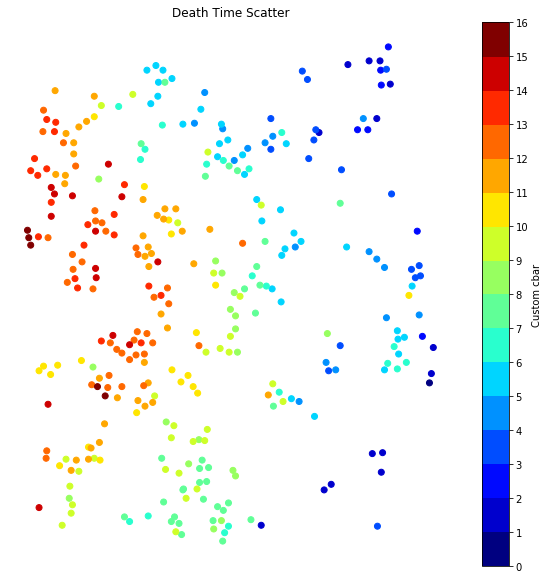

<Figure size 432x288 with 0 Axes>

In [29]:
draw_time_scatter(exp.lisX, exp.lisY, exp.die_times, exp.num_iterations)

In [0]:
def draw_death_perc_by_time(n_cells, die_times, num_iterations):
  death_by_time = [0] * num_iterations
  for i in range(n_cells):
    death_by_time[die_times[i]] += 1
  death_by_time_cum = np.cumsum(death_by_time)
  death_perc_by_time = [x / n_cells for x in death_by_time_cum]
  plt.plot(death_perc_by_time)
  plt.ylabel('Death Perc')
  plt.xlabel('Time of Death')
  plt.show()
  plt.clf()

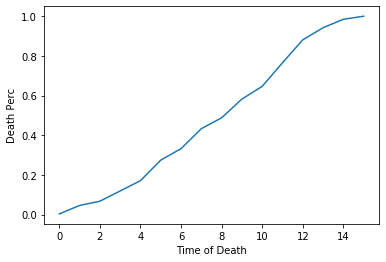

<Figure size 432x288 with 0 Axes>

In [31]:
draw_death_perc_by_time(exp.n_cells, exp.die_times, exp.num_iterations)

In [0]:
def draw_wave_scatter(death_wave_from_local_leader, lisX, lisY):
  n=max(death_wave_from_local_leader)
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]
  cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
  bounds = np.linspace(0, n, n + 1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  scat = ax.scatter(lisX, lisY, c=death_wave_from_local_leader, cmap=cmap, norm=norm)
  cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
  cb.set_label('Custom cbar')
  ax.set_title('Death Wave Scatter')
  plt.show()
  plt.clf()

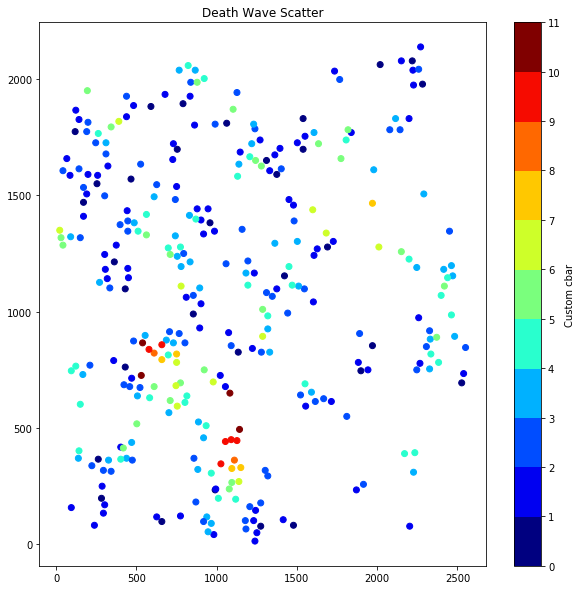

<Figure size 432x288 with 0 Axes>

In [45]:
draw_wave_scatter(death_wave_from_local_leader, exp.lisX, exp.lisY)